In [1]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### Figure 3 Left and Right
Environment has 3 states: ITI, S0 (ISI), S1. No Actions. <br>
<img src="./imgs/AddictionRedishFigS7.png" width="300px" align="left">


In [2]:
S = ['ITI', 'S0', 'S1']           # ITI Inter Trial Interval
Q = {'ITI':0, 'S0':0, 'S1':0}     # Initialization of the Q (state value function)
R = {'ITI':0, 'S0':0, 'S1':1}     # Reward function: We get reward when we transition from S0 to S1
D = {'ITI':0, 'S0':0, 'S1':0}     # Drug Dopamine boost, farmacological effect independent of states

alfa, gamma = 0.05, 0.02          # learning rate / dicount factor

def run(n=300):
    td_list = {'S0':[], 'S1':[]}
    for _ in range(n):
        # Without prerforming any action we experience the transition ITI -> S0 
        si,sj = 'ITI', 'S0'                                 # no learning ocurs in ITI when transitioning to S0
        td_error = R[sj]+gamma*Q[sj] - Q[si] + D[sj]        # In the paper ITI is modeled as 1000 states (but we don't)
                                                            # So no update of Q[si] in this case 
        td_list[sj] += [td_error]                           # We mantain 2 td_errors lists: 1) entering into S0 

        # Without prerforming any action we experience the transition S0 -> S1 
        si,sj = 'S0', 'S1'                                          
        td_error = max(D[sj], R[sj]+gamma*Q[sj] - Q[si] + D[sj])  # New td_error formula 
        #td_error = R[sj]+gamma*Q[sj] - Q[si] + D[sj]             # <- equal to the usual when D[s]=0
        Q[si] = Q[si] + alfa*td_error                             # We update Q(s)    
        td_list[sj] += [td_error]                                 # We mantain 2 td_errors lists: 2) entering into S1 
    return td_list
    
td_list = run()
print(Q)

{'ITI': 0, 'S0': 0.9999997924696653, 'S1': 0}


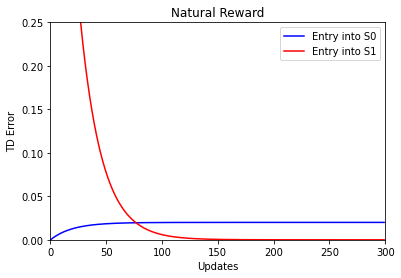

In [3]:
def plot(td_list, ax=None, color=None, label=None, title=None, xlabel='Updates', ylabel='TD Error', marker=None):
    if ax == None:
        _, ax = plt.subplots()
    plt.plot(td_list, label=label, color=color, marker=marker)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title:
        plt.title(title)
    if label:
        plt.legend()
    return ax

ax = plot(td_list['S0'], color='b', label='Entry into S0', title='Natural Reward')
plot(td_list['S1'], color='r', label='Entry into S1', ax=ax)
ax.set_ylim([0,.25])
ax.set_xlim([0,300])
plt.show()

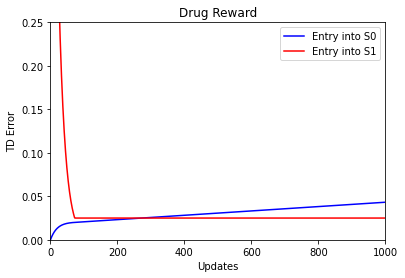

In [4]:
Q = {'ITI':0, 'S0':0, 'S1':0}
D = {'ITI':0, 'S0':0, 'S1':0.025}
exp=1000
td_list = run(n=exp)

ax = plot(td_list['S0'], color='b', label='Entry into S0', title='Drug Reward')
plot(td_list['S1'], color='r', label='Entry into S1', ax=ax)
ax.set_ylim([0,.25])
ax.set_xlim([0,exp])
plt.show()

### Second opportunity for delivering
Plot and comment what happens with different values of the learning rate alfa and the discount factor gamma. <BR>
You can look at the extremes also $\alpha = 0$, $\alpha = 1$ and $\gamma = 0$, $\gamma = 1$ <BR>
You can include several plots into figure as done in previous cell: <BR>


<AxesSubplot:title={'center':'Plotting several arrays'}, xlabel='x axis', ylabel='values'>

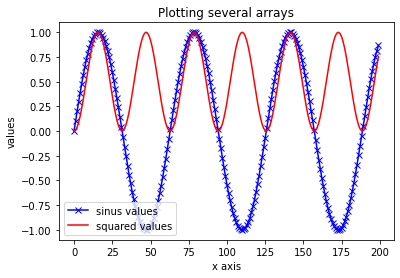

In [44]:
values = np.sin(np.arange(0,20,.1))  # some array of values to plot 
ax = plot(values, color='b', label='sinus values', title='Plotting several arrays', marker='x')           # first plot
plot([x*x for x in values], color='r', label='squared values',  xlabel='x axis', ylabel='values', ax=ax)  # second plot that is added as we pass the axes (ax)

### Figure 1 
Environment has 6 states and two actions in S0 <br>
<img src="./imgs/AddictionRedishFigS1.png" width="400px" align="left">

Softmax action selection <br> 
Probability of chosing actions: $\frac{e^{Q(s,a)/\tau}}{\sum_{a'\in A}{Q(s,a')}}$

In [6]:
def act_softmax_probs(qvalues,epsilon=.2):
    qvalues = np.array(qvalues)
    temp = 4*(epsilon+0.01)
    maxq = max(qvalues/temp)
    exp = np.exp(qvalues/temp - maxq)
    return exp/np.sum(exp)

/Users/marti/miniconda3/envs/sdic/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


(0.0, 1.0)

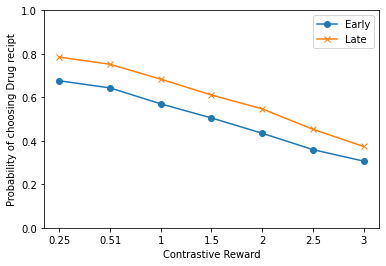

In [7]:
S = ['ITI', 'S0', 'S1', 'S2', 'S3', 'S4']          # ITI Inter Trial Interval : random delay in the paper 1000 states
A = ['N','D']

alfa = 0.05
gamma = .4
    
def run(n=1000,rc=1):
    Q,R,D = {},{},{}
    for s in S:
        Q[s],R[s],D[s] = 0,0,0
    R['S3'] = rc
    R['S4'] = 1
    D['S4'] = 0.025
    
    prob_list = []
    for t in range(n):
        si,sj = 'ITI', 'S0'
        td_error = gamma*(R[sj]+Q[sj]) - Q[si] + D[sj]           
        action_probs = act_softmax_probs([Q['S1'], Q['S2']])
        action = np.random.choice(2, 1, p=action_probs)[0] 

        if t==n-1:
            prob_list += [action_probs[1]]

        si,sj = 'S0', 'S1' if action == 0 else 'S2'
        td_error = max(D[sj], gamma*(R[sj]+Q[sj]) - Q[si] + D[sj])
        Q[si] = Q[si] + alfa*(td_error)             

        si,sj = sj, 'S3' if action == 0 else 'S4'
        td_error = max(D[sj], gamma*(R[sj]+Q[sj]) - Q[si] + D[sj])
        Q[si] = Q[si] + alfa*(td_error)             
    return prob_list


p_early, p_late = [], []
Rc = [0.25, 0.51, 1, 1.5, 2, 2.5, 3]
for rc in Rc:
    p_early += run(n=500, rc=rc)
    p_late += run(n=1000, rc=rc)

ax = plot(p_early, label='Early', marker='o')
plot(p_late,ax=ax, label='Late', xlabel='Contrastive Reward', ylabel='Probability of choosing Drug recipt', marker='x')
ax.set_xticklabels([''] + [str(r) for r in Rc])
ax.set_ylim([0,1])
